In [11]:
import os
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import zipfile
image_shape = (150,150,3)

In [7]:
# getting the weights of inception model v3 form google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-03 14:09:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com... 172.217.169.240
Connecting to storage.googleapis.com|172.217.169.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M  91.6KB/s    in 20m 8s  

2019-09-03 14:30:03 (71.1 KB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
# getting the cats vs dogs dataset
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O ./cats_and_dogs_filtered.zip

--2019-09-03 14:30:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com... 172.217.169.240
Connecting to storage.googleapis.com|172.217.169.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  50.1KB/s    in 16m 55s 

2019-09-03 14:47:10 (66.0 KB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
weight_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
# dont incloude the top 2 dense layers and load without any weights
pre_trained_model = InceptionV3(input_shape=image_shape, include_top=False, weights = None)
pre_trained_model.load_weights(weight_file)

W0903 14:51:44.155248 4828448192 deprecation.py:506] From /Users/mohsintariq/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# freeze all the pretrained layers 
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model= Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001), loss='binary_crossentropy', metrics = ['acc'])
model.summary()

W0903 14:52:21.246745 4828448192 deprecation.py:323] From /Users/mohsintariq/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./dataset')
zip_ref.close()

In [20]:
base_dir = './dataset/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fname = os.listdir(train_cats_dir)
train_dogs_fname = os.listdir(train_dogs_dir)

# dataset augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=10, class_mode='binary', target_size=(150,150))

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 137s - loss: 0.4777 - acc: 0.7840 - val_loss: 0.2427 - val_acc: 0.9340
Epoch 2/20
100/100 - 124s - loss: 0.3965 - acc: 0.8290 - val_loss: 0.3988 - val_acc: 0.9130
Epoch 3/20
100/100 - 108s - loss: 0.4124 - acc: 0.8170 - val_loss: 0.3506 - val_acc: 0.9270
Epoch 4/20
100/100 - 102s - loss: 0.3784 - acc: 0.8440 - val_loss: 0.3289 - val_acc: 0.9400
Epoch 5/20
100/100 - 106s - loss: 0.3787 - acc: 0.8450 - val_loss: 0.5555 - val_acc: 0.9190
Epoch 6/20
100/100 - 111s - loss: 0.3780 - acc: 0.8440 - val_loss: 0.4259 - val_acc: 0.9380
Epoch 7/20
100/100 - 112s - loss: 0.3570 - acc: 0.8530 - val_loss: 0.6980 - val_acc: 0.9040
Epoch 8/20
100/100 - 105s - loss: 0.3901 - acc: 0.8300 - val_loss: 0.3774 - val_acc: 0.9430
Epoch 9/20
100/100 - 112s - loss: 0.3305 - acc: 0.8610 - val_loss: 0.3072 - val_acc: 0.9540
Epoch 10/20
100/100 - 96s - loss: 0.3344 - acc: 0.8680 - val_loss: 0.8054 - val_acc: 0.9060
Epoch 11/20
100/100 - 96s - loss: 0.3452 - acc: 0.8690 - val_loss: 0.9066 - val_

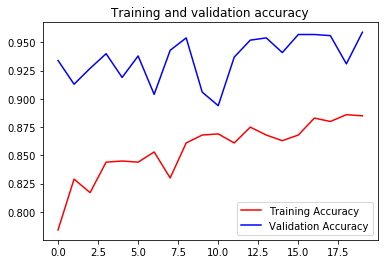

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation Accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [25]:
# saving the model and weights
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')